In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Je me positionne dans mon répertoire de travail personnel
os.chdir("C:\\Users\\Julien Gremillot\\OneDrive\\Documents\\" +
         "OpenClassrooms\\github\\" +
         "OpenClassrooms_Ingenieur_Machine_Learning\\" +
         "Catégorisez automatiquement des questions")

# Lecture des fichiers CSV issus du site "Query Stack Overflow"
fichiers_csv = []
for i in range(9):
    df = pd.read_csv('QueryResults_'+ str(i) + '.csv', sep=',',
                     index_col=None, header=0)
    fichiers_csv.append(df)

df = pd.concat(fichiers_csv, axis=0, ignore_index=True)

C:\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [2]:
print(df.shape)
print(df.columns)
df.head()

(188065, 23)
Index(['Id', 'PostTypeId', 'AcceptedAnswerId', 'ParentId', 'CreationDate',
       'DeletionDate', 'Score', 'ViewCount', 'Body', 'OwnerUserId',
       'OwnerDisplayName', 'LastEditorUserId', 'LastEditorDisplayName',
       'LastEditDate', 'LastActivityDate', 'Title', 'Tags', 'AnswerCount',
       'CommentCount', 'FavoriteCount', 'ClosedDate', 'CommunityOwnedDate',
       'ContentLicense'],
      dtype='object')


,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,...,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,ContentLicense
0,4,1,7,NaN,2008-07-31 21:42:52,NaN,737,60139,<p>I want to use a <code>Track-Bar</code> to c...,8,...,2021-02-26 03:31:15,2021-02-26 03:31:15,How to convert a Decimal to a Double in C#?,<c#><floating-point><type-conversion><double><...,14,5,57,NaN,2012-10-31 16:42:47,CC BY-SA 4.0
1,6,1,31,NaN,2008-07-31 22:08:08,NaN,309,21903,<p>I have an absolutely positioned <code>div</...,9,...,2021-01-29 18:46:45,2021-01-29 18:46:45,Why did the width collapse in the percentage w...,<html><css><internet-explorer-7>,7,1,12,NaN,NaN,CC BY-SA 4.0
2,9,1,1404,NaN,2008-07-31 23:40:59,NaN,2051,695724,<p>Given a <code>DateTime</code> representing ...,1,...,2021-01-05 17:33:32,2021-09-24 16:38:57,How do I calculate someone's age based on a Da...,<c#><.net><datetime>,67,10,479,NaN,2011-08-16 19:40:43,CC BY-SA 4.0
3,11,1,1248,NaN,2008-07-31 23:55:37,NaN,1591,181198,<p>Given a specific <code>DateTime</code> valu...,1,...,2017-06-04 15:51:19,2021-09-01 21:49:09,Calculate relative time in C#,<c#><datetime><time><datediff><relative-time-s...,40,3,550,NaN,2009-09-04 13:15:59,CC BY-SA 3.0
4,17,1,26,NaN,2008-08-01 05:09:55,NaN,194,81781,"<p>How do I store binary data in <a href=""http...",2,...,2020-12-03 03:37:51,2020-12-03 03:37:51,Binary Data in MySQL,<mysql><database><binary-data><data-storage>,9,3,22,2018-11-29 15:36:04,NaN,CC BY-SA 3.0


On examine les colonnes de dates pour avoir une idée de l'étendue de notre jeu de données

In [3]:
print('Nombre de lignes avec une CreationDate nulle:',
      len(df[df['CreationDate'].isna()]), '/', len(df))
print('Nombre de lignes avec une LastEditDate nulle:',
      len(df[df['LastEditDate'].isna()]), '/', len(df))
print('Nombre de lignes avec une ClosedDate nulle:',
      len(df[df['ClosedDate'].isna()]), '/', len(df))
print('Nombre de lignes avec une CommunityOwnedDate nulle:',
      len(df[df['CommunityOwnedDate'].isna()]), '/', len(df))
print('Nombre de lignes avec une DeletionDate nulle:',
      len(df[df['DeletionDate'].isna()]), '/', len(df))

Nombre de lignes avec une CreationDate nulle: 0 / 188065
Nombre de lignes avec une LastEditDate nulle: 6 / 188065
Nombre de lignes avec une ClosedDate nulle: 176231 / 188065
Nombre de lignes avec une CommunityOwnedDate nulle: 186424 / 188065
Nombre de lignes avec une DeletionDate nulle: 188065 / 188065


Je renseigne les LastEditDate manquantes avec la CreationDate.

In [4]:
df.loc[df['LastEditDate'].isna(), 'LastEditDate'] = df['CreationDate']
print('Nombre de lignes avec une LastEditDate nulle:',
      len(df[df['LastEditDate'].isna()]), '/', len(df))

Nombre de lignes avec une LastEditDate nulle: 0 / 188065


In [5]:
df.drop('DeletionDate', axis=1, inplace=True)
print(df.shape)
print(df.columns)

(188065, 22)
Index(['Id', 'PostTypeId', 'AcceptedAnswerId', 'ParentId', 'CreationDate',
       'Score', 'ViewCount', 'Body', 'OwnerUserId', 'OwnerDisplayName',
       'LastEditorUserId', 'LastEditorDisplayName', 'LastEditDate',
       'LastActivityDate', 'Title', 'Tags', 'AnswerCount', 'CommentCount',
       'FavoriteCount', 'ClosedDate', 'CommunityOwnedDate', 'ContentLicense'],
      dtype='object')


In [6]:
print(df['PostTypeId'].unique())

[1]


Je supprime la colonne 'PostTypeId' qui vaut toujours '1'.

In [7]:
df.drop('PostTypeId', axis=1, inplace=True)
print(df.shape)
print(df.columns)

(188065, 21)
Index(['Id', 'AcceptedAnswerId', 'ParentId', 'CreationDate', 'Score',
       'ViewCount', 'Body', 'OwnerUserId', 'OwnerDisplayName',
       'LastEditorUserId', 'LastEditorDisplayName', 'LastEditDate',
       'LastActivityDate', 'Title', 'Tags', 'AnswerCount', 'CommentCount',
       'FavoriteCount', 'ClosedDate', 'CommunityOwnedDate', 'ContentLicense'],
      dtype='object')


In [8]:
print(df['ParentId'].unique())

[nan]


Je supprime la colonne ParentId qui n'est jamais renseignée dans nos données.

In [9]:
df.drop('ParentId', axis=1, inplace=True)
print(df.shape)
print(df.columns)

(188065, 20)
Index(['Id', 'AcceptedAnswerId', 'CreationDate', 'Score', 'ViewCount', 'Body',
       'OwnerUserId', 'OwnerDisplayName', 'LastEditorUserId',
       'LastEditorDisplayName', 'LastEditDate', 'LastActivityDate', 'Title',
       'Tags', 'AnswerCount', 'CommentCount', 'FavoriteCount', 'ClosedDate',
       'CommunityOwnedDate', 'ContentLicense'],
      dtype='object')


In [10]:
print(df['ContentLicense'].unique())

['CC BY-SA 4.0' 'CC BY-SA 3.0' 'CC BY-SA 2.5']


J'examine le taux de remplissage des colonnes restantes.

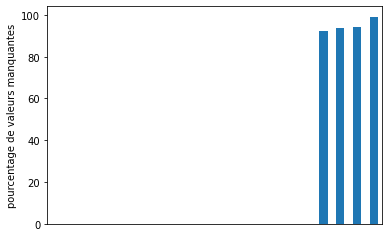

                       pourcentage_manquant
OwnerDisplayName                  92.071890
ClosedDate                        93.707495
LastEditorDisplayName             93.997288
CommunityOwnedDate                99.127429


In [13]:
def show_missing_data(data, pourcentage_manquant):
    percent_missing = data.isnull().sum() * 100 / len(data)
    missing_values = pd.DataFrame({'pourcentage_manquant': percent_missing})
    missing_values.sort_values('pourcentage_manquant', inplace=True)
    ax1 = missing_values["pourcentage_manquant"].plot(kind='bar')
    ax1.xaxis.set_visible(False)
    plt.ylabel("pourcentage de valeurs manquantes")
    plt.show()
    print(missing_values[missing_values["pourcentage_manquant"] > pourcentage_manquant])
    
show_missing_data(df, 1)

Je supprime les 4 colonnes dont le taux de remplissage est inférieur à 10%, les autres colonnes étant très bien renseignées.

In [14]:
df.drop(['OwnerDisplayName', 'ClosedDate',
         'LastEditorDisplayName', 'CommunityOwnedDate'],
        axis=1, inplace=True)
print(df.shape)
print(df.columns)

(188065, 16)
Index(['Id', 'AcceptedAnswerId', 'CreationDate', 'Score', 'ViewCount', 'Body',
       'OwnerUserId', 'LastEditorUserId', 'LastEditDate', 'LastActivityDate',
       'Title', 'Tags', 'AnswerCount', 'CommentCount', 'FavoriteCount',
       'ContentLicense'],
      dtype='object')


Score :
 [   11    12    13 ... 18427 23231 25869] 



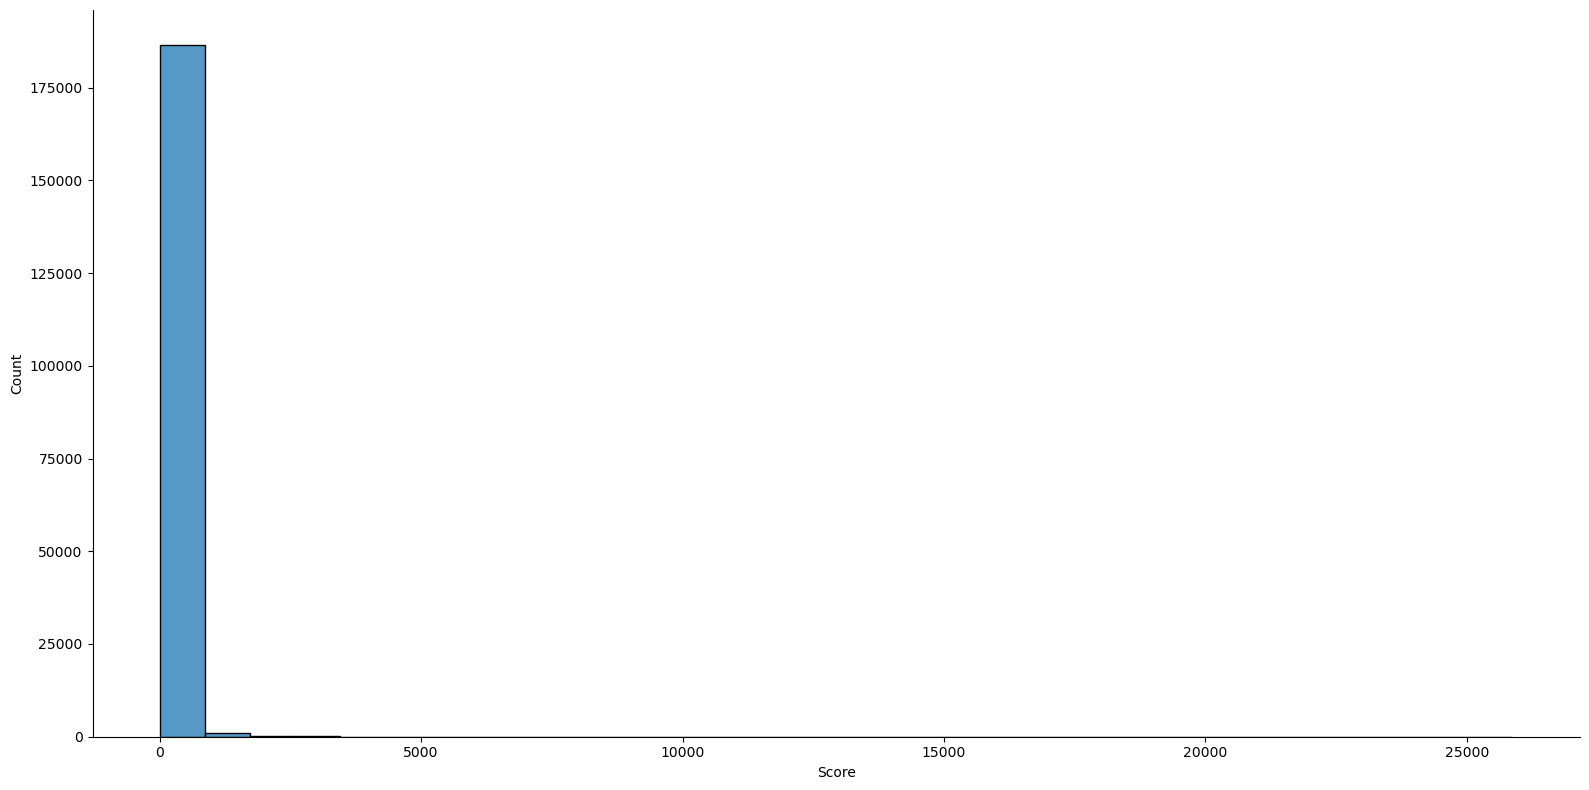

AnswerCount :
 [  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  67  68  69  71  72  73  74  75
  76  77  78  80  82  83  84  85  86  87  88  90  97  99 100 103 105 106
 108 112 114 118 121 135 182] 



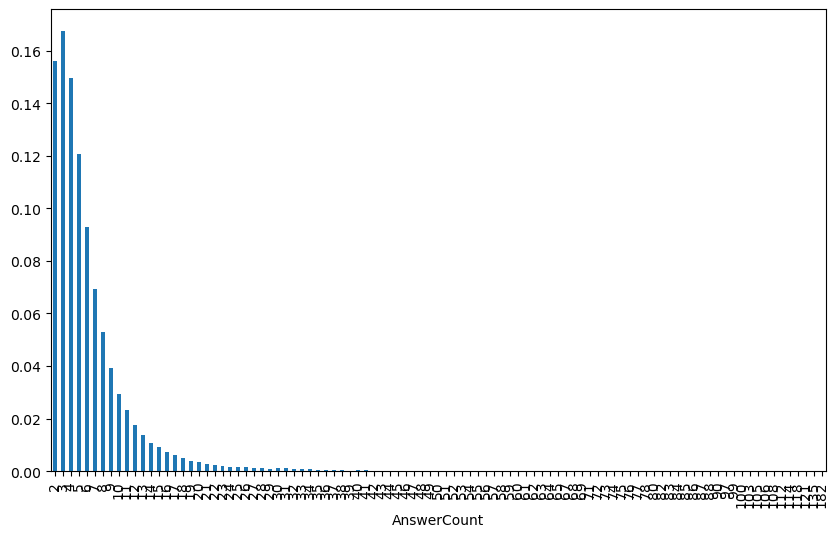

ContentLicense :
 ['CC BY-SA 2.5' 'CC BY-SA 3.0' 'CC BY-SA 4.0'] 



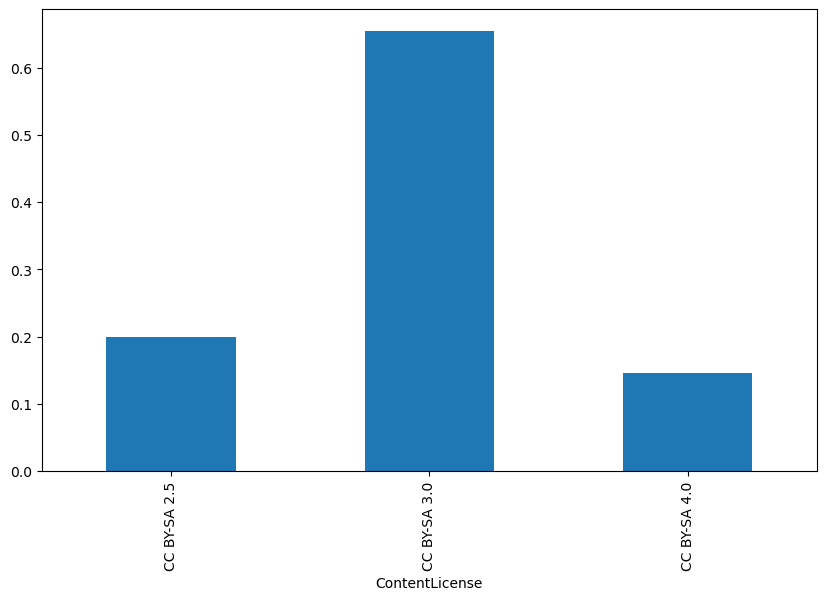

In [22]:
def show_distribution_col(data, col):
    plt.rcParams['figure.figsize']=(10,6)
    uniques = data[~data[col].isna()][col].unique()
    uniques.sort()
    print(col, ":\n", uniques, "\n")
    if col in ['Score', '---', '----']:
        sns.displot(df, x=col, bins=30, height=8, aspect=2)
        #plt.locator_params(axis='x', nbins=20) # pour une question de lisibilité
    else:
        # certaines colonnes sont à trier en fonction de l'index
        if col in ['AnswerCount', 'Score', 'ContentLicense', '-----']:
            groups_count = data[~data[col].isna()][col].value_counts(normalize=True, sort=False).sort_index(ascending=True)
        else:
            groups_count = data[~data[col].isna()][col].value_counts(normalize=True, sort=True)
        groups_count.plot(kind='bar')
        plt.xlabel(col)
    plt.show()
    plt.rcdefaults()
    
show_distribution_col(df, 'Score')
show_distribution_col(df, 'AnswerCount')
show_distribution_col(df, 'ContentLicense')